In [22]:
from __future__ import print_function, division

import numpy as np
import os
import pickle

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms

import sklearn.model_selection as model_selection

In [23]:
# Import data set
spectrogram_list = []
with open('nparr_spec_image.pickle','rb') as modelFile:
     spectrogram_list = pickle.load(modelFile)

In [24]:
print(spectrogram_list[0][0].shape)

(303, 722)


In [25]:
print(np.matrix(spectrogram_list[0][0]))

[[166 176 176 ... 241 241 241]
 [165 175 175 ... 255 255 255]
 [165 175 175 ... 255 255 255]
 ...
 [238 252 252 ... 255 255 255]
 [237 251 251 ... 255 255 255]
 [237 251 251 ... 255 255 255]]


# Import Model

In [35]:
# Initialize ResNet model with initial weights
tf_model = models.resnet18(weights = models.ResNet18_Weights.DEFAULT)

In [36]:
print(tf_model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Modify initial and last layers to allow model to adapt to our inputs/outputs.

In [37]:
# Get last layer and reset last linear layer
last_name, last_layer = list(tf_model.named_modules())[-1]
tf_model.fc = nn.Linear(in_features=512, out_features=10, bias=True)

# Prepend initial layers
tf_model.conv1 = nn.Sequential(
    nn.Conv2d(1, 3, kernel_size= (9,9), stride=(4,4), padding=(3,3)),
    nn.BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
    nn.ReLU(inplace=True),
    tf_model.conv1
)
print(tf_model.named_modules)

<bound method Module.named_modules of ResNet(
  (conv1): Sequential(
    (0): Conv2d(1, 3, kernel_size=(9, 9), stride=(4, 4), padding=(3, 3))
    (1): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  )
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tr

# Create Dataloaders

In [38]:
classes = ['bird', 'cat', 'chicken', 'cow', 'dog', 'donkey', 'frog', 'lion', 'monkey', 'sheep']
import operator
batch_size = 2

# Used from Google Gemini
from torch.utils.data import Dataset
class DAN_Dataset(Dataset):
    def __init__(self, data, labels, transform=None):
        self.data = torch.tensor(data)
        self.labels = torch.tensor(labels)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]


def fetch_dataloader(data, batch_size, train_transform=None, val_transform=None):
    '''
    Inputs:
    :param data: Data to load into DataLoaders.
    :param batch_size: Batch size for DataLoaders.
    :param train_transform: Transforms to apply to train Dataset
    :param val_transform: Transforms to apply to validation Dataset
    '''
    # https://www.geeksforgeeks.org/python-get-first-element-in-list-of-tuples/
    images = list(map(operator.itemgetter(0), spectrogram_list))
    images = np.array(images).astype(np.float32)
    # Grab lowercase labels and convert to integers
    labels = list(map(operator.itemgetter(1), spectrogram_list))
    labels = list(map(lambda x: x.lower(), labels))
    labels = list(map(lambda x: classes.index(x), labels))

    # Split into train and validation sets.
    x_train, x_val, y_train, y_val  = model_selection.train_test_split(images, labels, train_size=0.8, shuffle=True)
    # Convert to Dataset
    train_data = DAN_Dataset(x_train, y_train, train_transform)
    val_data = DAN_Dataset(x_val, y_val, val_transform)

    # Separate every 10th value
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=2)
    val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=True, num_workers=2)
    return train_loader, val_loader


train_transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.ConvertImageDtype(torch.float32),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

val_transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.ConvertImageDtype(torch.float32),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [39]:
train, val = fetch_dataloader(spectrogram_list, batch_size, train_transform, val_transform)

# Training

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

tf_model.to(device)
tf_model.train()

# Set the loss function and optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(tf_model.parameters(), lr=0.001, momentum=0.9)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Audio
#import sounddevice as sd
import os
import pickle

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import time
import os
import copy
import requests
#from bing_image_downloader import downloader
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import math
import random
import shutil

plt.ion()   # interactive mode



Finished Training


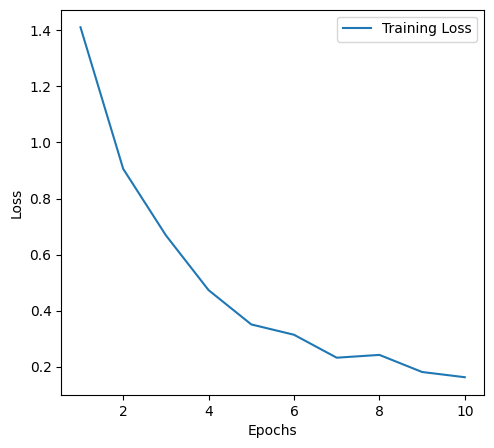

In [ ]:
train_losses = []
num_epochs = 10
for epoch in range(num_epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = torch.reshape(inputs, (4, 1, 303, 722))
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = tf_model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()

        if i % 1000 == 999:    # print every 1000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 1000))
            running_loss = 0.0
    train_losses.append(running_loss/len(train))

print('Finished Training')

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Evaluate Model

In [ ]:
# Gemini generated code with google search: "pytorch evaluate accuracy of model"
!pip install torchmetrics
from torchmetrics import Accuracy
criterion = nn.CrossEntropyLoss()

def evaluate_model(model, data_val, classes, device):
    num_epochs = 10
    test_losses = []

    test_accuracies = []


    for epoch in range(num_epochs):
      model.eval()
      predictions = []
      accuracy = Accuracy(task='multiclass', num_classes=classes).to(device)
      with torch.no_grad():
          running_loss = 0.0
          running_corrects = 0
          for i, data in enumerate(data_val, 0):
              # get the inputs; data is a list of [inputs, labels]
              try:
                  inputs, labels = data
                  inputs = torch.reshape(inputs, (inputs.shape[0], 1, 303, 722))
                  inputs = inputs.to(device)
                  labels = labels.to(device)
                  outputs = model(inputs)
                  loss = criterion(outputs, labels)
                  predictions.append(outputs)
                  accuracy.update(outputs, labels)
                  _, preds = torch.max(outputs, 1)
              except:
                  continue
              running_loss += loss.item() * inputs.size(0)
              running_corrects += torch.sum(preds == labels).detach().cpu().numpy()
      test_losses.append(running_loss / len(data_val))
      test_accuracies.append(running_corrects/ len(data_val))

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, num_epochs+1), test_losses, label='Testing Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(1, num_epochs+1), test_accuracies, label='Testing Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

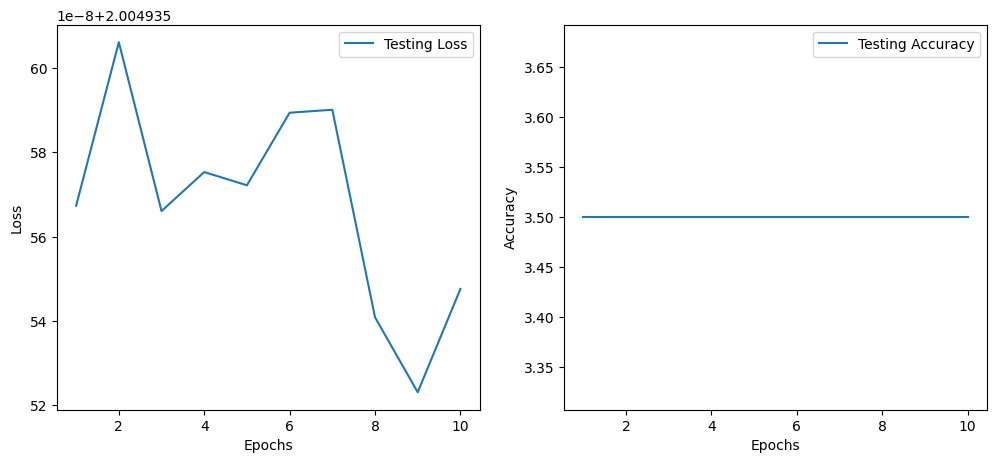

In [ ]:
predictions = []
evaluate_model(tf_model, val, 10, device)
# print("Accuracy: ", accuracy)

# pred_labels = []
# for batch in predictions:
#     for prediction in batch:
#         x = (prediction == torch.max(prediction)).nonzero(as_tuple=False)[0]
#         pred_labels.append(x)
# pred_labels = list(map(lambda x: x.cpu().numpy().item(), pred_labels))
# print(pred_labels)
# print(classes)

In [ ]:
from torchsummary import summary

summary(tf_model, (1, 303, 722))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 3, 76, 180]             246
       BatchNorm2d-2           [-1, 3, 76, 180]               6
              ReLU-3           [-1, 3, 76, 180]               0
            Conv2d-4           [-1, 64, 38, 90]           9,408
       BatchNorm2d-5           [-1, 64, 38, 90]             128
              ReLU-6           [-1, 64, 38, 90]               0
         MaxPool2d-7           [-1, 64, 19, 45]               0
            Conv2d-8           [-1, 64, 19, 45]          36,864
       BatchNorm2d-9           [-1, 64, 19, 45]             128
             ReLU-10           [-1, 64, 19, 45]               0
           Conv2d-11           [-1, 64, 19, 45]          36,864
      BatchNorm2d-12           [-1, 64, 19, 45]             128
             ReLU-13           [-1, 64, 19, 45]               0
       BasicBlock-14           [-1, 64,

Attempt

In [ ]:
# Gemini generated code with google search: "pytorch evaluate accuracy of model"
!pip install torchmetrics
from torchmetrics import Accuracy

def evaluate_model(model, data_val, classes, device):
    model.eval()
    predictions = []
    accuracy = Accuracy(task='multiclass', num_classes=classes).to(device)
    with torch.no_grad():
        for i, data in enumerate(data_val, 0):
            # get the inputs; data is a list of [inputs, labels]
            try:
                inputs, labels = data
                inputs = torch.reshape(inputs, (inputs.shape[0], 1, 303, 722))
                inputs = inputs.to(device)
                labels = labels.to(device)
                outputs = model(inputs)
                predictions.append(outputs)
                accuracy.update(outputs, labels)
            except:
                continue
        return accuracy.compute(), predictions

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 926.4/926.4 kB 12.4 MB/s eta 0:00:00


In [ ]:
predictions = []
accuracy, predictions = evaluate_model(tf_model, val, 10, device)
print("Accuracy: ", accuracy)

pred_labels = []
for batch in predictions:
    for prediction in batch:
        x = (prediction == torch.max(prediction)).nonzero(as_tuple=False)[0]
        pred_labels.append(x)
pred_labels = list(map(lambda x: x.cpu().numpy().item(), pred_labels))
print(pred_labels)
print(classes)

Accuracy:  tensor(0.8971)
[1, 1, 0, 0, 1, 1, 0, 4, 1, 4, 4, 4, 4, 0, 0, 1, 7, 4, 4, 4, 5, 0, 1, 3, 4, 0, 5, 1, 4, 4, 7, 9, 2, 1, 6, 0, 1, 0, 7, 1, 3, 8, 9, 1, 1, 5, 0, 1, 1, 0, 8, 6, 0, 0, 4, 1, 4, 0, 6, 6, 0, 2, 7, 4, 5, 5, 5, 4, 4, 1, 3, 7, 6, 1, 9, 9, 0, 1, 0, 4, 3, 4, 1, 7, 0, 6, 6, 8, 0, 1, 0, 6, 1, 7, 1, 1, 1, 4, 0, 4, 1, 8, 3, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 9, 1, 4, 4, 4, 0, 3, 0, 1, 0, 4, 1, 1, 1, 4, 4, 4, 0, 7, 3, 1, 3, 1, 4, 1, 4, 0, 0, 3, 5, 4, 4, 0, 2, 3, 1, 3, 1, 3, 1, 8, 1, 3, 2, 1, 1, 2, 4, 0, 1, 4, 9, 8, 1, 0, 0, 1, 8, 0, 4, 4]
['bird', 'cat', 'chicken', 'cow', 'dog', 'donkey', 'frog', 'lion', 'monkey', 'sheep']


In [40]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

tf_model.to(device)
tf_model.train()

# We need to set the loss function, the optimizer, and the learning rate scheduler
criterion = nn.CrossEntropyLoss()
# though we're fine tuning, we're updating all parameters
optimizer_ft = optim.SGD(tf_model.parameters(), lr=0.001, momentum=0.9)
# the scheduler decreases the learning rate by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Finished Training


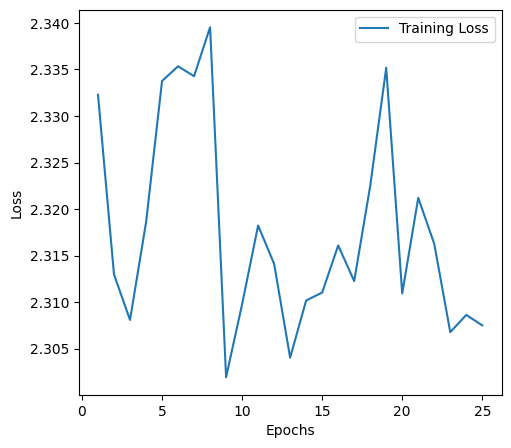

In [41]:
train_losses = []
num_epochs = 25
for epoch in range(num_epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = torch.reshape(inputs, (4, 1, 303, 722))
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = tf_model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()

        if i % 1000 == 999:    # print every 1000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 1000))
            running_loss = 0.0
    exp_lr_scheduler.step()
    train_losses.append(running_loss/len(train))

print('Finished Training')

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

In [42]:
# Gemini generated code with google search: "pytorch evaluate accuracy of model"
!pip install torchmetrics
from torchmetrics import Accuracy

def evaluate_model(model, data_val, classes, device):
    model.eval()
    predictions = []
    accuracy = Accuracy(task='multiclass', num_classes=classes).to(device)
    with torch.no_grad():
        for i, data in enumerate(data_val, 0):
            # get the inputs; data is a list of [inputs, labels]
            try:
                inputs, labels = data
                inputs = torch.reshape(inputs, (inputs.shape[0], 1, 303, 722))
                inputs = inputs.to(device)
                labels = labels.to(device)
                outputs = model(inputs)
                predictions.append(outputs)
                accuracy.update(outputs, labels)
            except:
                continue
        return accuracy.compute(), predictions

In [43]:
predictions = []
accuracy, predictions = evaluate_model(tf_model, val, 10, device)
print("Accuracy: ", accuracy)

pred_labels = []
for batch in predictions:
    for prediction in batch:
        x = (prediction == torch.max(prediction)).nonzero(as_tuple=False)[0]
        pred_labels.append(x)
pred_labels = list(map(lambda x: x.cpu().numpy().item(), pred_labels))
print(pred_labels)
print(classes)

Accuracy:  tensor(0.1886)
[4, 4, 4, 9, 4, 9, 0, 0, 4, 4, 4, 0, 4, 0, 4, 0, 4, 2, 2, 4, 4, 4, 2, 2, 2, 4, 4, 4, 2, 5, 4, 2, 1, 2, 5, 1, 2, 2, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 4, 1, 0, 4, 0, 9, 2, 4, 2, 4, 4, 2, 0, 9, 9, 4, 4, 2, 4, 0, 4, 0, 4, 0, 2, 2, 9, 5, 4, 1, 9, 2, 4, 2, 4, 4, 2, 4, 2, 0, 4, 4, 4, 2, 4, 4, 4, 4, 2, 2, 2, 4, 4, 2, 4, 2, 9, 5, 5, 2, 2, 2, 4, 4, 1, 4, 2, 4, 4, 0, 4, 0, 5, 4, 4, 4, 4, 4, 5, 4, 4, 4, 2, 4, 2, 1, 2, 2, 2, 2, 0, 2, 4, 2, 4, 4, 2, 2, 4, 4, 5, 4, 4, 4, 0, 5, 2, 4, 9, 2, 4, 2, 2, 2, 4, 2, 1, 9, 2, 0, 4, 4, 0, 4, 9, 0]
['bird', 'cat', 'chicken', 'cow', 'dog', 'donkey', 'frog', 'lion', 'monkey', 'sheep']
